In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import networkx as nx
import ipywidgets as widgets
import collections

from IPython.display import display
from IPython.display import clear_output

In [2]:
class Spremnik:
    def __init__(self):
        self.container = np.array([], dtype=int) 
        
    # za koristenje print(class)
    def __str__(self):
        return str(self.container)
    
    # za koristenje len(class)
    def __len__(self):
        return self.container.size
    
    # za koristenje display(class)
    def __repr__(self):
        return str(self.container)
    
    # za indeksiranje
    def __getitem__(self, index):
        return self.container[index]
    
    # vraca prvi element spremnika
    def front(self):
        return self.container[0]
    
    # brise prvi element iz spremnika i vraca ga
    def pop(self):
        val = self.container[0]
        self.container = np.delete(self.container, 0)
        return val
    
    # vraca velicinu spremnika
    def size(self):
        return self.q.size
   
    # provjerava je li red prazan
    def empty(self):
        return self.container.size == 0
    
    # vraca spremnik u obrnutom poretku
    def flip(self):
        self.container = np.flip(self.container)
        return self
    
    # provjerava postoji li element s tim keyjem
    def isin(self, val):
        return np.any(np.isin(self.container, val))
      
class Queue(Spremnik):
    # dodaje vrijednost na kraj reda
    def push(self, val):      
        self.container = np.insert(self.container, len(self.container), val)
        
class Stack(Spremnik):
    # dodaje vrijednost na pocetak stoga
    def push(self, val):
        self.container = np.insert(self.container, 0, val)

In [3]:
class PriorityQueue():
    def __init__(self, tip=np.dtype(np.int)): 
        self.keys = np.array([], dtype=tip) 
        self.values = np.array([], dtype=tip)
    
    # za koristenje print(class)
    def __str__(self):
        return str(np.vstack((self.keys, self.values)))
    
    # za koristenje display(class)
    def __repr__(self):
        return str(np.vstack((self.keys, self.values)))
    
    # sortira red po value vrijednosti
    def sort(self):
        mask = self.values.argsort()
        
        self.keys = self.keys[mask]
        self.values = self.values[mask]
    
    # provjerava je li red prazan
    def empty(self):
        return self.keys.size == 0
    
    # brise prvi element iz reda i vraca ga
    def pop(self):
        key = self.keys[0]
        value = self.values[0]
        
        self.keys = np.delete(self.keys, 0)
        self.values = np.delete(self.values, 0)
        return key, value
    
    # dodaje element u red
    def push(self, val):
        self.keys = np.insert(self.keys, 0, val[0])
        self.values = np.insert(self.values, 0, val[1])
        
        self.sort()
    
    # provjerava postoji li element s tim keyjem
    def isin(self, val):
        return np.any(np.isin(self.keys, val))
    
    # mijenja value za zadani key
    def set(self, key, val):
        try:
            pos = np.where(self.keys == key)[0][0]

            self.values[pos] = val
            self.sort()
        except:
            display("Element ne postoji!")

In [4]:
# funkcija koja vraca put od pocetnog cvora do ciljnog cvora
# algoritmi najcesce vracaju put od ciljnog cvora do pocetnog puta
# pa ga treba obrnuti
def dohvati_put(roditelj_cvora, pocetni_cvor, ciljni_cvor):
    q = Stack()
    trenutni_cvor = ciljni_cvor
    
    while trenutni_cvor != pocetni_cvor:
        q.push(trenutni_cvor)
        trenutni_cvor = roditelj_cvora[trenutni_cvor]
        
    q.push(trenutni_cvor)
    
    return q

In [5]:
def BFS(graph, pocetni_cvor, ciljni_cvor, brojac=99999):
    # deklariram i inicijaliziram spremnike za algoritam
    q = Queue()
    q.push(pocetni_cvor)

    posjeceni_cvorovi = np.zeros(len(graph), dtype=int)
    
    roditelj_cvora = np.zeros(len(graph), dtype=int)
    roditelj_cvora[pocetni_cvor] = pocetni_cvor;

    put_obilaska_stabla = Stack()
    
    # kreiram tablicu i dodajem red u nju
    tablica = pd.DataFrame([], columns=['susjedi', 'trenutni cvor', 'red', 'lista_posjecenih'])
    tablica = tablica.append(pd.Series(['-', '-', str(q), '-'], index=tablica.columns ), ignore_index=True)
    
    # algoritam staje ako je prioritetni red prazan ili za interektivni prikaz 
    # ako smo odradili zadani broj koraka
    while q.empty() == False and brojac != 0:
        trenutni_cvor = q.pop()
        posjeceni_cvorovi[pocetni_cvor] = True
        
        if trenutni_cvor == ciljni_cvor:
            # dodajem cvor u stack i dodajem red u tablicu
            put_obilaska_stabla.push(trenutni_cvor)
            
            tablica = tablica.append(pd.Series(['-', str(trenutni_cvor), '-', str(put_obilaska_stabla)], index=tablica.columns ), 
                           ignore_index=True
                          )
            
            return { 'put' : dohvati_put(roditelj_cvora, pocetni_cvor, ciljni_cvor), 
                     'put_obilaska' : put_obilaska_stabla.flip(),
                     'tablica' : tablica
                   }

        for susjedni_cvor in sorted(graph[trenutni_cvor]):
            if posjeceni_cvorovi[susjedni_cvor] == False:
                posjeceni_cvorovi[susjedni_cvor] = True
                roditelj_cvora[susjedni_cvor] = trenutni_cvor
                q.push(susjedni_cvor)

        # dodajemo redak u tablicu s podacima ako nismo bili u tom cvoru do sada
        if put_obilaska_stabla.isin(trenutni_cvor) == False:
            put_obilaska_stabla.push(trenutni_cvor)
            
            red = pd.Series([str(sorted(graph[trenutni_cvor])), str(trenutni_cvor), str(q), str(put_obilaska_stabla)], 
                            index=tablica.columns
                           )
            
            tablica = tablica.append(red, ignore_index=True)
        
        brojac = brojac - 1
    
    return {'put_obilaska' : put_obilaska_stabla.flip(),
            'tablica' : tablica
           }

In [6]:
def DFS(graph, pocetni_cvor, ciljni_cvor, brojac=99999):
    # deklariram i inicijaliziram spremnike za algoritam
    s = Stack()
    s.push(pocetni_cvor)
    
    posjeceni_cvorovi = np.zeros(len(graph), dtype=bool)
    
    roditelj_cvora = np.zeros(len(graph), dtype=int)
    roditelj_cvora[pocetni_cvor] = pocetni_cvor;
    
    put_obilaska_stabla = Stack()
    
    # kreiram tablicu i dodajem red u nju
    tablica = pd.DataFrame([], columns=['susjedi', 'trenutni cvor', 'stog', 'lista_posjecenih'])
    tablica = tablica.append(pd.Series(['-', '-', str(s), '-'], index=tablica.columns ), ignore_index=True)
    
    # algoritam staje ako je prioritetni red prazan ili za interektivni prikaz 
    # ako smo odradili zadani broj koraka
    while s.empty() == False and brojac != 0:
        trenutni_cvor = s.pop()
        
        if trenutni_cvor == ciljni_cvor:
            # dodajem cvor u stack i dodajem red u tablicu
            put_obilaska_stabla.push(trenutni_cvor)
            
            tablica = tablica.append(pd.Series(['-', str(trenutni_cvor), '-', str(put_obilaska_stabla)], index=tablica.columns ), ignore_index=True)
            
            return {'put' : dohvati_put(roditelj_cvora, pocetni_cvor, ciljni_cvor),
                    'put_obilaska' : put_obilaska_stabla.flip(),
                    'tablica' : tablica
                   }
        
        if posjeceni_cvorovi[trenutni_cvor] == False:
            posjeceni_cvorovi[trenutni_cvor] = True
            
            for susjedni_cvor in sorted(graph[trenutni_cvor], reverse = True):
                 if posjeceni_cvorovi[susjedni_cvor] == False:
                    roditelj_cvora[susjedni_cvor] = trenutni_cvor
                    s.push(susjedni_cvor)

        # dodajemo redak u tablicu s podacima ako nismo bili u tom cvoru do sada
        if put_obilaska_stabla.isin(trenutni_cvor) == False:
            put_obilaska_stabla.push(trenutni_cvor)
            
            red = pd.Series([str(sorted(graph[trenutni_cvor])), str(trenutni_cvor), str(s), str(put_obilaska_stabla)], index=tablica.columns) 
            tablica = tablica.append(red, ignore_index=True)
        
        brojac = brojac - 1
    
    return {'put_obilaska' : put_obilaska_stabla.flip(),
            'tablica' : tablica
           }

In [7]:
# inicijaliziram globalne varijable
broj_cvorova = 10
pocetni_cvor = 1
ciljni_cvor = 4

C:\Users\nivuc\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


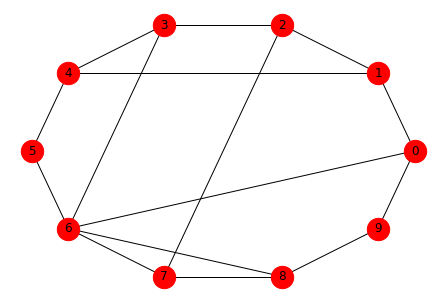

In [8]:
# generiram random povezan graf
graph_BFS_DFS = nx.generators.random_graphs.newman_watts_strogatz_graph(broj_cvorova, 3, 0.7, np.random.randint(10000))

pos_graph_BFS_DFS = nx.shell_layout(graph_BFS_DFS)
nx.draw(graph_BFS_DFS, pos_graph_BFS_DFS, node_size=500, with_labels=True, node_color='red')

In [9]:
def ispisi_output_BFS_DFS():
    
    # brisem sve sto je ispisano u prijasnjem koraku
    clear_output(wait=True)
    
    # ispisujem gumbe na ekran
    display(HBox_BFS_DFS, output_BFS_DFS)

    # dohvacam podatke algoritama
    podaci_BFS_DFS = {'BFS' : BFS(graph_BFS_DFS, pocetni_cvor, ciljni_cvor, brojac_BFS_DFS),
                      'DFS' : DFS(graph_BFS_DFS, pocetni_cvor, ciljni_cvor, brojac_BFS_DFS)
                     }
    
    # iscrtavam tablice
    display(podaci_BFS_DFS['BFS']['tablica'])
    display(podaci_BFS_DFS['DFS']['tablica'])
    
    colors_BFS_DFS = [ 'yellow', 'red' ]
    
    # inicijaliziram boje cvorova za BFS
    posjeceni_BFS = np.zeros(len(graph_BFS_DFS), dtype=int)
    np.put(posjeceni_BFS, podaci_BFS_DFS['BFS']['put_obilaska'], 1)
    
    node_colors_BFS = [ colors_BFS_DFS[posjeceni_BFS[i]] for i in range(len(graph_BFS_DFS)) ] 
    
    # inicijaliziram boje cvorova za DFS
    posjeceni_DFS = np.zeros(len(graph_BFS_DFS), dtype=int)
    np.put(posjeceni_DFS, podaci_BFS_DFS['DFS']['put_obilaska'], 1)
    
    node_colors_DFS = [ colors_BFS_DFS[posjeceni_DFS[i]] for i in range(len(graph_BFS_DFS)) ] 
    
    # crtam bfs graf
    plt.subplot(1, 2, 1)   
    nx.draw(graph_BFS_DFS, pos_graph_BFS_DFS, node_size=300, with_labels=True, node_color=node_colors_BFS)
    
    # crtam dfs graf
    plt.subplot(1, 2, 2)   
    nx.draw(graph_BFS_DFS, pos_graph_BFS_DFS, node_size=300, with_labels=True, node_color=node_colors_DFS)
    
def sljedeci_BFS_DFS_clicked(b):
    global brojac_BFS_DFS
    
    # brojac ne moze biti veci od broja koraka algoritma 
    brojac_BFS_DFS = min(brojac_BFS_DFS + 1, broj_koraka_algoritma_BFS_DFS)
        
    ispisi_output_BFS_DFS()
        
def prethodni_BFS_DFS_clicked(b):
    global brojac_BFS_DFS

    # brojac ne moze biti manji od nule
    brojac_BFS_DFS = max(0, brojac_BFS_DFS - 1)
        
    ispisi_output_BFS_DFS()
    
# definiram gumbe
sljedeci_BFS_DFS = widgets.Button(description=">")
prethodni_BFS_DFS = widgets.Button(description="<")
output_BFS_DFS = widgets.Output()
HBox_BFS_DFS = widgets.HBox([prethodni_BFS_DFS, sljedeci_BFS_DFS])

sljedeci_BFS_DFS.on_click(sljedeci_BFS_DFS_clicked)
prethodni_BFS_DFS.on_click(prethodni_BFS_DFS_clicked)

Output()

,susjedi,trenutni cvor,red,lista_posjecenih
0,-,-,[1],-


,susjedi,trenutni cvor,stog,lista_posjecenih
0,-,-,[1],-


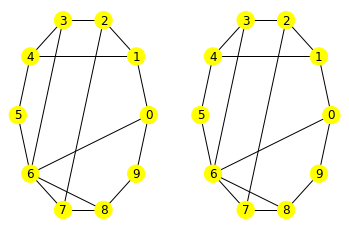

In [10]:
# dohvacam podatke algoritama
podaci_BFS_DFS = {'BFS' : BFS(graph_BFS_DFS, pocetni_cvor, ciljni_cvor),
                  'DFS' : DFS(graph_BFS_DFS, pocetni_cvor, ciljni_cvor)
                 }

# brojac za ispisivanje tablice
brojac_BFS_DFS = 0

broj_posjecenih_cvorova_BFS = len(podaci_BFS_DFS['BFS']['put_obilaska'])
broj_posjecenih_cvorova_DFS = len(podaci_BFS_DFS['DFS']['put_obilaska'])
                                  
broj_koraka_algoritma_BFS_DFS = max(broj_posjecenih_cvorova_BFS, broj_posjecenih_cvorova_DFS) + 1

ispisi_output_BFS_DFS()

In [11]:
def Dijkstra(graph, pocetni_cvor, brojac=99999):
    
    # deklariram i inicijaliziram sve potrebne spremnike za algoritam
    udaljenosti = np.zeros(len(graph), dtype=int)
    roditelj_cvora = np.zeros(len(graph), dtype=int)
    posjeceni_cvorovi = np.zeros(len(graph), dtype=bool)
    
    roditelj_cvora[pocetni_cvor] = pocetni_cvor
    
    q = PriorityQueue()
    q.push((pocetni_cvor, 0))
    
    # dohvacam tezine
    weights = nx.get_edge_attributes(graph,'weight')
    
    # kreiram tablicu
    tablica = pd.DataFrame([], columns=['cvor', 'posjeceni', 'cijene', 'put'])
    
    # inicijaliziram potrebne spremnike i dodajem za svaki cvor red u tablicu
    for cvor in graph.nodes:
        if cvor != pocetni_cvor:
            # promjeni ovo kasnije
            udaljenosti[cvor] = 99999
            roditelj_cvora[cvor] = -1
            
            q.push((cvor, udaljenosti[cvor]))
        
        # red koji cu dodat u tablicu
        red = pd.Series([cvor, posjeceni_cvorovi[cvor], udaljenosti[cvor], roditelj_cvora[cvor]], 
                        index=tablica.columns 
                       )
        tablica = tablica.append(red, ignore_index=True)    
    
    # algoritam staje ako je prioritetni red prazan ili za interektivni prikaz 
    # ako smo odradili zadani broj koraka
    while q.empty() == False and brojac != 0:
        trenutni_cvor, value = q.pop()
        
        posjeceni_cvorovi[trenutni_cvor] = True
        
        # postavimo u tablici da je cvor posjecen
        tablica.at[trenutni_cvor, 'posjeceni'] = posjeceni_cvorovi[trenutni_cvor]
        
        for susjedni_cvor in sorted(graph[trenutni_cvor]):
            
            # graph[cvor] nije simetricna relacija
            # npr. imam (0, 1) ali nemam (1, 0), pa ovako izbjegavam pristup necemu sto nije definirano
            u = min(trenutni_cvor, susjedni_cvor)
            v = max(trenutni_cvor, susjedni_cvor)
            
            nova_udaljenost = udaljenosti[trenutni_cvor] + weights[u, v]
            if nova_udaljenost < udaljenosti[susjedni_cvor]:
                
                udaljenosti[susjedni_cvor] = nova_udaljenost
                roditelj_cvora[susjedni_cvor] = trenutni_cvor
                
                # azuriram tablicu
                tablica.at[susjedni_cvor, 'cijene'] = udaljenosti[susjedni_cvor]
                tablica.at[susjedni_cvor, 'put'] = roditelj_cvora[trenutni_cvor]
                
                q.set(susjedni_cvor, nova_udaljenost)
            
        brojac = brojac - 1
            
    return {'udaljenosti' : udaljenosti, 
            'roditelj_cvora' : roditelj_cvora, 
            'tablica' : tablica          
           }


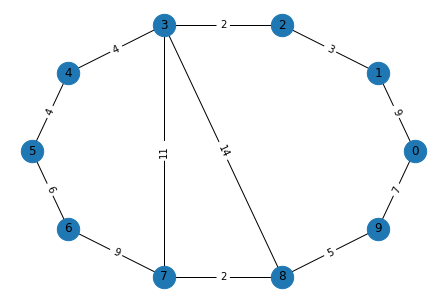

In [12]:
# generiram random povezan graf
graph_Dijkstra = nx.generators.random_graphs.newman_watts_strogatz_graph(broj_cvorova, 2, 0.4, np.random.randint(10000))

for (u, v, w) in graph_Dijkstra.edges(data=True):
    w['weight'] = np.random.randint(1, 15)

pos_graph_Dijkstra = nx.shell_layout(graph_Dijkstra)
nx.draw(graph_Dijkstra, pos_graph_Dijkstra, node_size=500, with_labels=True)

weights = nx.get_edge_attributes(graph_Dijkstra,'weight')
nx.draw_networkx_edge_labels(graph_Dijkstra, pos_graph_Dijkstra, edge_labels=weights);

In [13]:
def ispisi_output_Dijkstra():

    # pobrisem sve sto je ispisano u prijasnjem koraku
    clear_output(wait=True)
    
    # ispisem gumbe na ekran
    display(HBox_Dijkstra, output_Dijkstra)
    
    # algoritam odraduje odredeni broj koraka
    podaci_Dijkstra = Dijkstra(graph_Dijkstra, 3, brojac_Dijkstra)
    display(podaci_Dijkstra['tablica'])
    
    # u cvorove upisujem do sad izracunatu udaljenost od pocetnog cvora
    cijene_Dijkstra = podaci_Dijkstra['tablica']['cijene']
    labels_map_Dijkstra = { i : cijene_Dijkstra[i] for i in range(len(graph_Dijkstra)) }
    
    # postavljam boje za cvorove
    colors_Dijkstra = ['yellow', 'red']
    posjeceni_Dijkstra = podaci_Dijkstra['tablica']['posjeceni']
    node_colors_Dijkstra = [ colors_Dijkstra[int(posjeceni_Dijkstra[i])] for i in range(len(graph_Dijkstra))]
    
    # crtam graf
    nx.draw(graph_Dijkstra, pos_graph_Dijkstra, node_size=500, 
            with_labels=True, labels=labels_map_Dijkstra, node_color=node_colors_Dijkstra)
    nx.draw_networkx_edge_labels(graph_Dijkstra, pos_graph_Dijkstra, edge_labels=weights);

def sljedeci_Dijkstra_clicked(b):
    global brojac_Dijkstra
    
    # brojac ne moze biti veci od broja koraka algoritma    
    brojac_Dijkstra = min(brojac_Dijkstra + 1, len(H))
        
    ispisi_output_Dijkstra()
        
def prethodni_Dijkstra_clicked(b):
    global brojac_Dijkstra
      
    # brojac ne moze biti manji od nule
    brojac_Dijkstra = max(0, brojac_Dijkstra - 1)
        
    ispisi_output_Dijkstra()

# definiram gumbe
sljedeci_Dijkstra = widgets.Button(description=">")
prethodni_Dijkstra = widgets.Button(description="<")
output_Dijkstra = widgets.Output()
HBox_Dijkstra = widgets.HBox([prethodni_Dijkstra, sljedeci_Dijkstra])

# gumbima zadajem funkcije koje ce se izvrsiti na event
sljedeci_Dijkstra.on_click(sljedeci_Dijkstra_clicked)
prethodni_Dijkstra.on_click(prethodni_Dijkstra_clicked)

Output()

,cvor,posjeceni,cijene,put
0,0,False,99999,-1
1,1,False,99999,-1
2,2,False,99999,-1
3,3,False,0,3
4,4,False,99999,-1
5,5,False,99999,-1
6,6,False,99999,-1
7,7,False,99999,-1
8,8,False,99999,-1
9,9,False,99999,-1


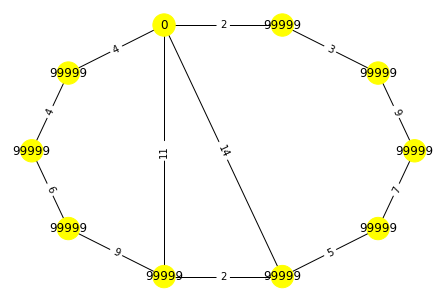

In [14]:
brojac_Dijkstra = 0;

ispisi_output_Dijkstra()

In [15]:
def A_star(graph, pocetni_cvor, ciljni_cvor, h, brojac=9999):   
    # deklariram i inicijaliziram sve potrebne spremnike za algoritam
    h_val = [ h(pos_graph_A_star[i], pos_graph_A_star[ciljni_cvor]) for i in range(len(graph)) ]
    
    p = PriorityQueue()
    p.push((pocetni_cvor, h_val[pocetni_cvor]))
    
    posjeceni_cvorovi = np.zeros(len(graph), dtype=bool)
    
    roditelj_cvora = np.zeros(len(graph), dtype=int)
    roditelj_cvora[pocetni_cvor] = pocetni_cvor
        
    najkraca_udaljenost = np.zeros(len(graph), dtype=int)
    najkraca_udaljenost[pocetni_cvor] = 0
    
    ukupna_udaljenost = np.zeros(len(graph), dtype=float)
    ukupna_udaljenost[pocetni_cvor] = najkraca_udaljenost[pocetni_cvor] + h_val[pocetni_cvor]

    # dohvacam tezine i inicijaliziram brojac koji ce mi kasnije trebati za interaktivni prikaz
    weights = nx.get_edge_attributes(graph, 'weight')
    broj_koraka_algoritma = 0
    
    # kreiram tablicu
    tablica = pd.DataFrame([], columns=['cvor', 'posjeceni', 'udaljenost', 'heuristika', 'ukupna udaljenost', 'roditelj'])
    
    # inicijaliziram potrebne spremnike i dodajem za svaki cvor red u tablicu
    for cvor in graph.nodes:
        if cvor != pocetni_cvor:
            najkraca_udaljenost[cvor] = 99999
            ukupna_udaljenost[cvor] = 99999
            roditelj_cvora[cvor] = -1
        
        # red koji cu dodati u tablicu
        red = pd.Series([cvor, 
                         posjeceni_cvorovi[cvor], 
                         najkraca_udaljenost[cvor], 
                         h_val[cvor], 
                         ukupna_udaljenost[cvor], 
                         roditelj_cvora[cvor]], index=tablica.columns 
                       )
        
        # dodajem u tablicu red
        tablica = tablica.append(red, ignore_index=True) 
    
    # algoritam staje ako je prioritetni red prazan ili za interektivni prikaz 
    # ako smo odradili zadani broj koraka
    while p.empty() == False and brojac != 0:
        trenutni_cvor, value = p.pop()
        posjeceni_cvorovi[trenutni_cvor] = True
        
        # azuriram tablicu 
        tablica.at[trenutni_cvor, 'posjeceni'] = posjeceni_cvorovi[trenutni_cvor]
        
        broj_koraka_algoritma = broj_koraka_algoritma + 1
        
        if trenutni_cvor == ciljni_cvor:
            return {'broj_koraka_algoritma' : broj_koraka_algoritma,
                    'put' : dohvati_put(roditelj_cvora, pocetni_cvor, ciljni_cvor),
                    'tablica' : tablica 
                   }
        
        for susjedni_cvor in sorted(graph[trenutni_cvor]):
            
            # graph[cvor] nije simetricna relacija
            # npr. imam (0, 1) ali nemam (1, 0), pa ovako izbjegavam pristup necemu sto nije definirano
            u = min(trenutni_cvor, susjedni_cvor)
            v = max(trenutni_cvor, susjedni_cvor)
            
            nova_udaljenost = najkraca_udaljenost[trenutni_cvor] + weights[u, v]
            if nova_udaljenost < najkraca_udaljenost[susjedni_cvor]:
                
                roditelj_cvora[susjedni_cvor] = trenutni_cvor

                najkraca_udaljenost[susjedni_cvor] = nova_udaljenost
                ukupna_udaljenost[susjedni_cvor] = nova_udaljenost + h_val[susjedni_cvor]
                
                # azuriram tablicu
                tablica.at[susjedni_cvor, 'roditelj'] = roditelj_cvora[susjedni_cvor]
                tablica.at[susjedni_cvor, 'udaljenost'] = najkraca_udaljenost[susjedni_cvor]
                tablica.at[susjedni_cvor, 'ukupna udaljenost'] = ukupna_udaljenost[susjedni_cvor]
                
                if posjeceni_cvorovi[susjedni_cvor] == False:
                    p.push((susjedni_cvor, ukupna_udaljenost[susjedni_cvor]))
                    
        brojac = brojac - 1

    # ne vracam najkraci put jer nije izracunat!
    return {'broj_koraka_algoritma' : broj_koraka_algoritma, 
            'tablica' : tablica 
           }

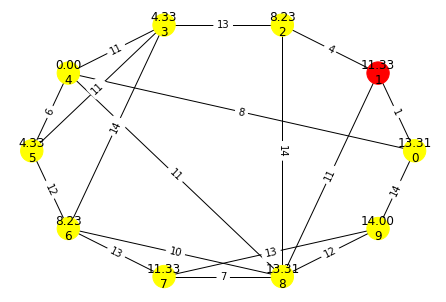

In [16]:
# generiram random povezan graf
graph_A_star = nx.generators.random_graphs.newman_watts_strogatz_graph(broj_cvorova, 3, 0.7, np.random.randint(10000))

# definiram heuristiku
alfa = 7
h = lambda a, b : np.linalg.norm(b - a) * alfa
    
# definiram pozicije
pos_graph_A_star = nx.shell_layout(graph_A_star)

# definiram labele, u cvoru ce pisat vrijednost heuristike i ime čvora
labels_map_A_star = {i : format(h(pos_graph_A_star[i], pos_graph_A_star[ciljni_cvor]), '.2f')+"\n"+str(i) 
                    for i in range(len(graph_A_star))}

# postavljam boju cvorova u zuto i pocetni cvor u crveno
node_colors_A_star = ['yellow' for i in range(len(graph_A_star))]
node_colors_A_star[pocetni_cvor]='red'

# crtam graf
nx.draw(graph_A_star, pos_graph_A_star, node_size=500, with_labels=True, 
        node_color=node_colors_A_star, labels=labels_map_A_star)

# dodajem tezine
for (u, v, w) in graph_A_star.edges(data=True):
    w['weight'] = np.random.randint(1, 15)

#crtam tezine
weights = nx.get_edge_attributes(graph_A_star,'weight')
nx.draw_networkx_edge_labels(graph_A_star, pos_graph_A_star, edge_labels=weights);

In [17]:
def ispisi_output_A_star():    
    # brisem sve sto je ispisano u prijasnjem koraku
    clear_output(wait=True)
    
    # ispisujem gumbe na ekran
    display(HBox_A_star, output_A_star)
    display(najkraci_put_A_star)
    
    # algoritam odraduje odreden broj koraka
    podaci_A_star = A_star(graph_A_star, pocetni_cvor, ciljni_cvor, h, brojac_A_star);
    display(podaci_A_star['tablica'])
    
    # postavljam boje za cvorove
    colors_A_star = ['yellow', 'red']
    posjeceni_A_star = podaci_A_star['tablica']['posjeceni']
    node_colors_A_star = [ colors_A_star[int(posjeceni_A_star[i])] for i in range(len(graph_A_star))]
    
    # crtam graf
    nx.draw(graph_A_star, pos_graph_A_star, node_size=500, with_labels=True, node_color=node_colors_A_star)
    nx.draw_networkx_edge_labels(graph_A_star, pos_graph_A_star, edge_labels=weights);
    
def sljedeci_A_star_clicked(b):
    global brojac_A_star
    
    # brojac ne moze biti veci od broja koraka algoritma
    brojac_A_star = min(brojac_A_star + 1, broj_koraka_algoritma_A_star)

    ispisi_output_A_star()
        
def prethodni_A_star_clicked(b):
    global brojac_A_star
        
    # brojac ne moze biti manji od nule
    brojac_A_star = max(0, brojac_A_star - 1)
        
    ispisi_output_A_star()
    
# definiram gumbe
sljedeci_A_star = widgets.Button(description=">")
prethodni_A_star = widgets.Button(description="<")
output_A_star = widgets.Output()
HBox_A_star = widgets.HBox([prethodni_A_star, sljedeci_A_star])

# gumbima zadajem funkcije koje ce se izvrsiti na event
sljedeci_A_star.on_click(sljedeci_A_star_clicked)
prethodni_A_star.on_click(prethodni_A_star_clicked)

Output()

[1 0 4]

,cvor,posjeceni,udaljenost,heuristika,ukupna udaljenost,roditelj
0,0,False,99999,13.314792,99999.000000,-1
1,1,False,0,11.326238,11.326238,1
2,2,False,99999,8.228994,99999.000000,-1
3,3,False,99999,4.326238,99999.000000,-1
4,4,False,99999,0.000000,99999.000000,-1
5,5,False,99999,4.326238,99999.000000,-1
6,6,False,99999,8.228994,99999.000000,-1
7,7,False,99999,11.326238,99999.000000,-1
8,8,False,99999,13.314792,99999.000000,-1
9,9,False,99999,14.000000,99999.000000,-1


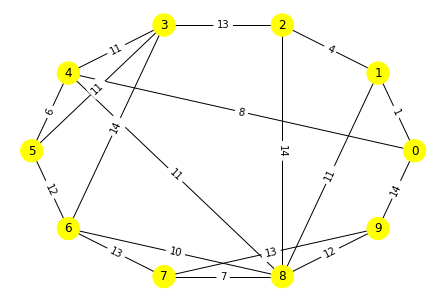

In [18]:
# dohvacam podatke, ne znam potreban broj koraka za algoritam
# pa ga pozivam jednom da ih izracuna i da  dohvatim ostale podatke
podaci_A_star = A_star(graph_A_star, pocetni_cvor, ciljni_cvor, h)
broj_koraka_algoritma_A_star = podaci_A_star['broj_koraka_algoritma']
najkraci_put_A_star = podaci_A_star['put']

brojac_A_star = 0;

# funkcija za ispis
ispisi_output_A_star()